In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from collections import namedtuple

from time import perf_counter
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from pprint import pprint

import tensorflow as tf
import tensorflow_probability as tfp

from gemlib.util import compute_state
from gemlib.distributions import DiscreteTimeStateTransitionModel
from gemlib.distributions import UniformInteger
from gemlib.distributions import UniformKCategorical

tfd = tfp.distributions

## Discrete-time general stochastic SIR epidemic model

In the discrete-time General Stochastic Epidemic model (GSE), we assume individuals transition from Susceptible to Infectious to Removed.  Let the numbers of Susceptible, Infectious, and Removed individuals at time $t$ be denoted by $S_t$, $I_t$, and $R_t$ respectively, and that $S_t + I_t + R_t = N$ the total population size.

We assume that at time $t$, each Susceptible individual experiences _infectious pressure_
$$
\lambda_t = \beta I_t / N
$$
equal to the rate at which each individual transitions to the $I$ state.  Similarly, each Infected individual transitions to the $R$ state at rate $\gamma$ constant with time.

Given a population of size $N=1000$, an infection rate $\beta=0.3$, removal rate of $\gamma=0.14$, and with one initial infected individual, the chain binomial model evolves the system over $T_{max}=70$ discrete time steps of size $\Delta t$ according to the following algorithm:

0. Initialise $t=0$, $S_t=999$, $I_t=1$, $R_t=0$
1. Draw $$I^\star \sim \mbox{Binomial}(S_t, 1 - e^{-\lambda_t Δt}) \\ R^\star \sim \mbox{Binomial}(I_t, 1 - e^{-\gamma \Delta t})$$
2. Update $$S_{t+1} = S_t - I^\star \\ I_{t+1} = I_t + I^\star - R^\star \\ R_{t+1} = R_t + R^\star$$
3. Goto 1 while $t < T_{max}$

We implement this below using `gemlib`'s `DiscreteTimeStateTransitionModel`:

In [5]:
stoichiometry = np.array([[-1, 1, 0],
                          [0, -1, 1]],
                         dtype=np.float32)
init_state = np.array([[999.0, 1.0, 0.0]], dtype=np.float32)

def hazard_fn(t, state):
    si = 0.3 * state[..., 1] / tf.reduce_sum(state, axis=-1)
    ir = tf.constant([0.14])
    return [si, ir]

model = DiscreteTimeStateTransitionModel(transition_rates=hazard_fn, 
                                         initial_state=init_state, 
                                         initial_step=0,
                                         time_delta=1.0,
                                         num_steps=70,
                                         stoichiometry=stoichiometry)

2022-01-26 09:25:01.649836: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-26 09:25:01.945008: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-26 09:25:01.945858: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-26 09:25:01.947186: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

## Sampling from the GSE model

We can draw a sample from our GSE epidemic model, and graph the resulting epidemic trajectory.  

The `model.sample()` method returns an _event list_, i.e. a tensor of shape `[M, T, R]` for $M=1$ sub-population, $T=70$ timesteps, and $R=2$ transitions. The number of timesteps is deliberately kept short, to ensure that the epidemic is "incomplete" -- i.e. the epidemic is not over. 

Given the event list, we then use `compute_state` to re-construct the _state timeseries_ $X_t = \{S_t$, $I_t$, $R_t\}$ for $t=0,\dots,69$ given $S_0, I_0, R_0$.

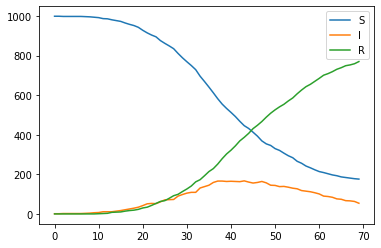

In [6]:
# Ensure we get an outbreak that takes off, as many stochastic
# epidemics will fade out in the first few timesteps.
while True:  
    events = model.sample()
    if tf.reduce_sum(events[...,1]) > 10:
        break
        
state = compute_state(initial_state=init_state, events=events, stoichiometry=stoichiometry)

plt.plot(state[0,...,0], label="S")
plt.plot(state[0,...,1], label="I")
plt.plot(state[0,...,2], label="R")
plt.legend()

# An observation model

Let us assume that in the real world we observe a proportion of $I->R$ transitions, being synonymous with an individual's infection being detected and them put into isolation.

Let $z^r_t$ be the number of removal events on day $t$, such that the observed number of new cases is
$$y_t \sim \mbox{Binomial}(z^r_t, q_t)$$
and $q=0.5$ the detection probability (e.g. sensitivity of a test, or reporting rate).

In [7]:
observation_process = tfd.Independent(
    distribution=tfd.Binomial(total_count=events[...,1],
                              probs=0.5),
    reinterpreted_batch_ndims=1
) # MxT

observed_cases = observation_process.sample()

# The Chain Binomial Rippler

In a situation like SARS-CoV-2, where models are required to produce real-time short-term projections of the epidemic, we wish to train the above model to historically observed data to estimate $\beta$, $\gamma$, and possibly $q$ and $S_0, I_0, R_0$.

Writing the number of $S\rightarrow I$ and $I\rightarrow R$ events each day as $\mathbf{z}$, we notice that $\mathbf{z}$ is censored -- we do not directly observe the number of state transitions happening per day.  In this case, the posterior distribution of the parameters is
$$
\pi(\beta, \gamma, q | \mathbf{y}, X_0) = \int_{Z} f(\mathbf{y} | \mathbf{z}, q) f(\mathbf{z} | \beta, \gamma, X_0)f(\beta)f(\gamma) \mathrm{d}\mathbf{z}.
$$

In practice, this integral is impossible to solve analytically due to the high dimension of $\mathbf{z}$ and therefore the size of its associated probability space.  We need, therefore, an MCMC scheme that explores the space of $\mathbf{z}$ efficiently in order to estimate the posterior distribution accurately.

In our current work, we update $\mathbf{z}$ (i.e. `events` above) using component-wise updates of elements $z_{mtr}$ sequentially for sub-population $m$, timepoint $t$, and transition $r$.  However, since components of $\mathbf{z}$ are highly dependent given the model, the sequential approach is able to perturb each $mtr$ element by only a small amount.  To move $\mathbf{z}$ a large distance in space, many sequential updates are required, leading to a slowly mixing MCMC chain. 

In the CBR (__chain binomial rippler__) algorithm, we take a different approach, in which whole sections of the (multidimensional for $m>1$) timeseries of events are updated at once.  Following an initial perturbation of events at a chosen timepoint in $[0, T)$, we re-construct the event timeseries that would have happened given our original model subsequent to $t^\star$.  

As shown in Algorithm 1 of the [draft paper](https://www.overleaf.com/read/gwxpkpwhxzmk), the algorithm iterates across $[t^\star+1, T)$, re-sampling from either Binomial or Hypergeometric distributions according to the differences between the original trajectory and the perturbed one.

### Implementation

In the file `chain_binomial_rippler.py`, the CBR implementation is divided into 3 main functions:

* `_dispatch_update` operates on an atomic timepoint/subpopulation/transition combination;
* `chain_binomial_rippler` the top level function that loops over the timepoints, subpopulation and transitions; 
* `_initial_ripple` which kicks off the perturbation by sampling $t^\star$ and a resampled $z^\star_t^\star$.

__Issue__: The question is how to optimise `_dispatch_update` since currently calls to `tf.switch` provide 
no possibility of vectorising the loops in `chain_binomial_rippler`.

### An example run

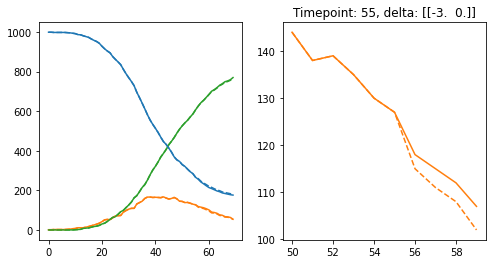

In [8]:
from chain_binomial_rippler import chain_binomial_rippler

while True:
    new_events, info = chain_binomial_rippler(model, events)
    if tf.reduce_any(new_events != events):  # Ensure we sample a different trajectory
        break
        
new_state = compute_state(initial_state=init_state, events=new_events, stoichiometry=model.stoichiometry)

fig, ax = plt.subplots(1, 2, figsize=[8, 4])
ax[0].plot(state[0,...,0], color='C0', label='S original')
ax[0].plot(state[0,...,1], color='C1', label='I original')
ax[0].plot(state[0,...,2], color='C2', label='R original')
ax[0].plot(new_state[0,...,0], '--', color='C0', label='S new')
ax[0].plot(new_state[0,...,1], '--', color='C1', label='I new')
ax[0].plot(new_state[0,...,2], '--', color='C2', label='R new')
lower = np.clip(info['timepoint'] - 5, 0, None)
upper = np.clip(lower + 10, None, state.shape[-2])
ax[1].plot(range(lower, upper), state[0, lower:upper, 1], color='C1')
ax[1].plot(range(lower, upper), new_state[0, lower:upper, 1], '--', color='C1')
_ = plt.title(f"Timepoint: {info['timepoint']}, delta: {info['delta']}")


# Proposal video

In the following video, we iteratively apply `update_trajectory` to the SI events, and look for random walk behaviour of the overall stochastic process trajectory. 

In [7]:
def make_chart_func(initial_events, model):
    
    fig, ax = plt.subplots()
    lineS, = ax.plot([], color='C0', label='S')
    lineI, = ax.plot([], color='C1', label='I')
    lineR, = ax.plot([], color='C2', label='R')
    ax.set_xlim(0, initial_events.shape[-2])
    ax.set_ylim(0, 1100)
    
    events = initial_events
    
    def chartfunc(t):
        nonlocal events
        events, info = chain_binomial_rippler(model, events)
        ax.set_title(f"Frame: {t}, t_idx: {info['timepoint']}, delta: {info['delta']}")
        new_state = compute_state(initial_state=model.initial_state, 
                                  events=events, 
                                  stoichiometry=model.stoichiometry)
        lineS.set_data((np.arange(new_state.shape[-2]), new_state[0,...,0]))
        lineI.set_data((np.arange(new_state.shape[-2]), new_state[0,...,1]))
        lineR.set_data((np.arange(new_state.shape[-2]), new_state[0,...,2]))   
    return fig, chartfunc

In [9]:
# This code is time-consuming, so only un-comment if you wish to see the video.
# import matplotlib.animation as ani

# fig, chartfunc = make_chart_func(events, model)
# anim = ani.FuncAnimation(fig, chartfunc, frames=500, interval=40)
# HTML(anim.to_html5_video())

### Embedding the CBR in an MCMC algorithm

First we embed the CBR within a derivation of `tfp.mcmc.TransitionKernel`:

In [10]:
from tensorflow_probability.python.mcmc.internal import util as mcmc_util
from tensorflow_probability.python.internal import samplers

CBRResults = namedtuple("CBRResults", ["target_log_prob", 
                                       "is_accepted", 
                                       "delta", 
                                       "current_state_t", 
                                       "initial_ripple", 
                                       "timepoint", 
                                       "seed"])

class CBRKernel(tfp.mcmc.TransitionKernel):
    
    def __init__(self, target_log_prob_fn, model, name=None):
        
        self._target_log_prob_fn = target_log_prob_fn
        self._model = model
        
        name = mcmc_util.make_name(
                name, "CBRKernel", ""
            )

        self._parameters = dict(
            target_log_prob_fn=target_log_prob_fn,
            model=model,
            name=name,
        )

    @property
    def is_calibrated(self):
        return True
    
    @property
    def target_log_prob(self):
        return self._target_log_prob_fn
    
    @property
    def model(self):
        return self._model
    
    @property
    def name(self):
        return self._parameters.name

    def one_step(self, current_state, previous_results, seed=None):
        
        with tf.name_scope("CBRKernel/one_step"):
            seed = samplers.sanitize_seed(seed, salt="cbr_kernel")
            
            proposed_state, proposal_trace = chain_binomial_rippler(model, current_state, seed=seed)
        
            proposed_target_log_prob = self.target_log_prob(proposed_state)
        
            delta_logp = proposed_target_log_prob - previous_results.target_log_prob
        
            def accept():
                return proposed_state, CBRResults(target_log_prob=proposed_target_log_prob,
                                                  is_accepted=tf.constant(True),
                                                  delta=proposal_trace['delta'],
                                                  current_state_t=proposal_trace['current_state_t'],
                                                  initial_ripple=proposal_trace['initial_ripple'],
                                                  timepoint=proposal_trace['timepoint'],
                                                  seed=seed)

            def reject():
                return current_state, CBRResults(target_log_prob=previous_results.target_log_prob,
                                                 is_accepted=tf.constant(False),
                                                 delta=proposal_trace['delta'],
                                                 current_state_t=proposal_trace['current_state_t'],
                                                 initial_ripple=proposal_trace['initial_ripple'],
                                                 timepoint=proposal_trace['timepoint'],
                                                 seed=seed)
        
            u = tf.math.log(tfd.Uniform().sample())
            return tf.cond(u < delta_logp,
                           accept,
                           reject)
    
    def bootstrap_results(self, current_state):
        with tf.name_scope("CBRKernel/bootstrap_results"):
            return CBRResults(target_log_prob=self.target_log_prob(current_state),
                              is_accepted=tf.constant(False),
                              delta=tf.zeros((1,2), current_state.dtype),
                              current_state_t=tf.zeros([current_state.shape[-3], self.model.stoichiometry.shape[-1]], current_state.dtype),
                              initial_ripple=tf.zeros((2, 1), current_state.dtype),
                              timepoint=tf.constant(0, dtype=tf.int32),
                              seed=samplers.zeros_seed(),
                             )

We then set up our `target_log_prob_fn` to incorporate our observation
model and simulated observed data. Note we need to reconstruct the 
observation Binomial random variable, as we must condition on the current 
MCMC state `current_events` (not to be confused with the epidemic 
state $\mathbf{X}$!).  Then build and sample using `CBRKernel`: 

In [17]:
def tlp_fn(current_events):
    observation_process = tfd.Binomial(total_count=current_events[...,1],
                                       probs=0.5)
    return tf.reduce_sum(observation_process.log_prob(observed_cases))

kernel = CBRKernel(target_log_prob_fn=tlp_fn, model=model, name='MyKernel')

@tf.function(jit_compile=False)
def sample(num_results):
    return tfp.mcmc.sample_chain(num_results=num_results, 
                                 current_state=tf.convert_to_tensor(events, name="initial_state"),
                                 kernel=kernel)

samples, results = sample(tf.constant(2)) # Compile graph

nsamples = 5000
with tf.device("CPU"):
    start = perf_counter()
    #tf.profiler.experimental.start("tf_logdir")
    samples, results = sample(tf.constant(nsamples))
    #tf.profiler.experimental.stop()
    end = perf_counter()

print("Mean it/s:", nsamples/(end-start))
print("Acceptance:", np.mean(results.is_accepted))

/home/jewellcp/Documents/Projects/bp_add_delete/.venv/lib/python3.8/site-packages/tensorflow_probability/python/mcmc/sample.py:342: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


Mean it/s: 52.51044660216155
Acceptance: 0.618


## Plot traces

''

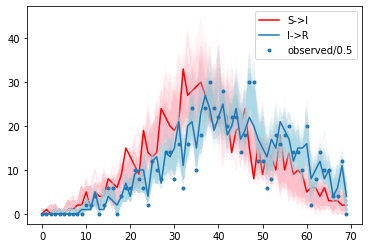

In [18]:
plt.plot(samples[::20, 0, :, 0].numpy().T, alpha=0.05, color='pink')
plt.plot(events[0, :, 0].numpy(), color='red', label="S->I")
plt.plot(samples[::20, 0, :, 1].numpy().T, alpha=0.05, color='lightblue')
plt.plot(events[0, :, 1].numpy(), color='C0', label="I->R")
plt.plot(range(samples.shape[-2]), observed_cases[0]*2, '.', label='observed/0.5')

plt.legend()
;

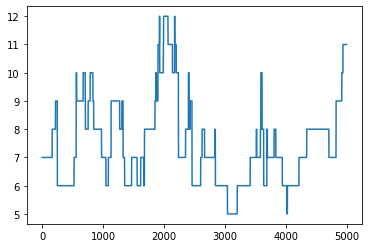

In [30]:
# Traceplot of number of I->R events at time 0 
plt.plot(samples[:, 0, 25, 1])

Calculate the proportion of proposals resulting in no move, i.e. $\Delta z_t = 0$

In [32]:
np.mean(results.delta[:, 0, 0] == 0.0)

0.1444

but the acceptance rate for moves where $\delta_{si} \ne 0$ is reasonably high

In [33]:
np.mean(results.is_accepted[results.delta[:, 0, 0] != 0])

0.5497896213183731

__Conclusion__: We may need a way of creating a bigger initial perturbation.